In [ ]:
!nvidia-smi

Mon May 22 14:21:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    46W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q --upgrade transformers diffusers ftfy huggingface_hub
!pip install -q accelerate
!pip install -q datasets
!pip install -q pytorch-lightning
!pip install -q einops
!pip install -q gradio
!pip install -q open_clip_torch
!pip install -q --upgrade omegaconf
!pip install -q opencv-contrib-python
!pip install -q controlnet_aux
!pip install -q invisible-watermark>=0.1.5
!pip install -q kornia==0.6
!pip install -qq fastai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 73.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from __future__ import print_function
import inspect
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import OneCycleLR
import os
from PIL import Image
import numpy as np
import random
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

from base64 import b64encode
import numpy as np
import json
import cv2
from diffusers import UNet2DModel, AutoencoderKL, UNet2DConditionModel 
from diffusers import DiffusionPipeline, StableDiffusionInpaintPipeline, DDPMPipeline
from diffusers import LMSDiscreteScheduler, DDPMScheduler
from diffusers.optimization import get_cosine_schedule_with_warmup
import subprocess

# For video display:
from IPython.display import HTML
from pathlib import Path
from torch import autocast
from torchvision import transforms as tfms
from transformers import logging, CLIPTextModel, CLIPTokenizer
from fastai.basics import show_image,show_images
from accelerate import Accelerator
from huggingface_hub import HfFolder, Repository, whoami

# torch.manual_seed(1)

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

from huggingface_hub import hf_hub_download
from huggingface_hub import notebook_login
from dataclasses import dataclass
from datasets import load_dataset
import pytorch_lightning as pl
from google.colab.patches import cv2_imshow
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
notebook_login()

In [ ]:
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse")
vae.to(device)
print('Added vae to cuda - vae.config.latent_channels : {vae.config.latent_channels} in_channels : {vae.config.in_channels}')

Added vae to cuda - vae.config.latent_channels : {vae.config.latent_channels} in_channels : {vae.config.in_channels}


###UNet training from scratch & loading the trained model

In [ ]:
@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 95
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 5
    save_model_epochs = 5
    mixed_precision = "no"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "ddpm-butterflies-128"  # the model name locally and on the HF Hub

    push_to_hub = True  # whether to upload the saved model to the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


config = TrainingConfig()

In [ ]:
config.dataset_name = "huggan/smithsonian_butterflies_subset"
train_dataset = load_dataset(config.dataset_name, split="train")

1000


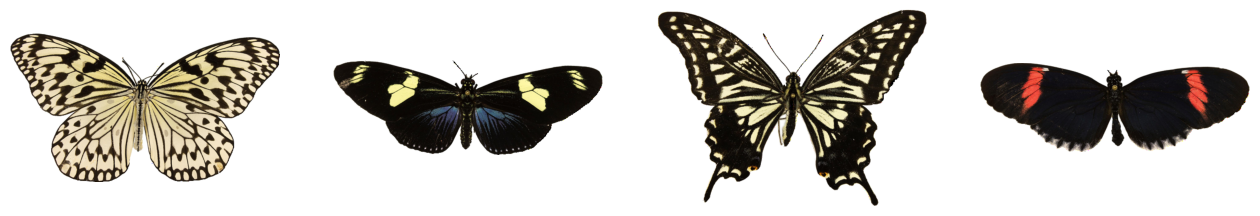

In [ ]:
print(len(train_dataset))
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(train_dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

In [ ]:
train_transforms = tfms.Compose([
    tfms.Resize((config.image_size, config.image_size)),
    tfms.ToTensor()
])

train_preprocess = tfms.Compose(
    [
        tfms.Resize((config.image_size, config.image_size)),
        tfms.RandomHorizontalFlip(),
        tfms.ToTensor(),
        tfms.Normalize([0.5], [0.5]),
    ]
)

def train_transform(examples):
    images = [train_preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

train_dataset.set_transform(train_transform)

train_dataloader = DataLoader(train_dataset, batch_size=config.train_batch_size, shuffle=True)

In [ ]:
def generate_mask_image_pil(img_batch, mode='train', eval_bs=0):

    if mode == 'train':
        bs = img_batch.shape[0]
        mask_img_tensor_list = []
        mask_tensor_list = []
    elif mode == 'eval':
        bs = eval_bs
        mask_img_pil_list = []
        mask_pil_list = []        

    for idx in range(bs):     
        # Move each image to cpu and convert to np array for CV2 operations   
        img = img_batch[idx].cpu().numpy()
        img = np.transpose(img, (1,2,0))
        # read the image
        img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

        # get the dimensions of the image
        height, width, _ = img.shape

        # calculate the desired patch area
        patch_area = 0.05 * height * width

        # generate random position for the patch
        x = np.random.randint(0, width)
        y = np.random.randint(0, height)

        # generate random number of vertices for the patch
        num_vertices = np.random.randint(3, 7)

        # generate random vertices for the patch until the patch area is reached
        vertices = []
        current_area = 0
        while current_area < 0.05 * patch_area:
            vertex_x = np.random.randint(0, width)
            vertex_y = np.random.randint(0, height)
            vertices.append((vertex_x, vertex_y))
            current_area = cv2.contourArea(np.array(vertices))
        # vertices = vertices[:-1]
        # create a white patch image with the same shape as the original image
        patch = np.zeros_like(img)
        cv2.fillPoly(patch, [np.array(vertices)], (255, 255, 255))

        # add the white patch to the image
        img = cv2.add(img, patch)
        img[img == 255] = 0

        # create a binary mask of the modified image
        mask = np.zeros((height, width), dtype=np.uint8)
        cv2.fillPoly(mask, [np.array(vertices)], 255)

        if mode == 'eval':
          img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_NEAREST)
          mask = cv2.resize(mask, (512, 512), interpolation=cv2.INTER_NEAREST)

        #Convert the masked image to PIL 
        img = img * 255
        img = img.astype(np.uint8)
        img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        #Convert the mask to PIL 
        mask_pil = Image.fromarray(mask) 
        
        if mode == 'train':
            #Converting the masked PIL image and PIL mask to tensor 
            mask_img_tensor = train_transforms(img_pil)
            mask_tensor = train_transforms(mask_pil)          
            #Appending these tensors to a list for stacking
            mask_img_tensor_list.append(mask_img_tensor)   
            mask_tensor_list.append(mask_tensor)
            # Stack masked images from the list to get a shape like [16, 3, 512, 512]
            mask_imgs = torch.stack(mask_img_tensor_list)
            # Stack masks from the list to get a shape like [16, 1, 512, 512]
            masks = torch.stack(mask_tensor_list)            
        elif mode == 'eval':
            #Appending these PIL images to a list
            mask_img_pil_list.append(img_pil)
            mask_pil_list.append(mask_pil)         
        
    if mode == 'train':

        return mask_imgs, masks

    elif mode == 'eval':
        return mask_img_pil_list, mask_pil_list

In [ ]:
def encode_image_to_latents(imgs):
    # if not isinstance(imgs, list):
    #     imgs = [imgs]

    # img_arr = np.stack([np.array(img) for img in imgs], axis = 0)
    # img_arr = img_arr / 255.0
    # img_arr = torch.from_numpy(img_arr).float().permute(0, 3, 1, 2)
    for img in imgs: 
        img_arr = 2 * (img - 0.5)

    latent_dists = vae.encode(imgs.to(device)).latent_dist.sample()
    latent_samples = latent_dists
    latent_samples *= vae.config.scaling_factor

    return latent_samples

def decode_latents_to_img(latents):
    latents = 1 / vae.config.scaling_factor * latents
    with torch.no_grad():
        image = vae.decode(latents).sample

    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    # images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [ ]:
def get_input_latent(image_batch):
    
    # Get the batch of image tensors from train loop 
    orig_imgs = image_batch["images"]
    
    # Get the batch of masked images tensor and masks tensor
    mask_imgs, masks = generate_mask_image_pil(orig_imgs, mode='train')
    
    # Pass the originial image tensor and masked images tensor through VAE to get latents
    orig_images_latent = encode_image_to_latents(orig_imgs)
    mask_images_latent = encode_image_to_latents(mask_imgs)
    
    # Change the shape of mask to suit the orig_images_latent shape for concat later in train loop
    masks_hw = [orig_images_latent.shape[-2], orig_images_latent.shape[-1]]
    masks_latent = torch.nn.functional.interpolate(masks, size=masks_hw)
    masks_latent = masks_latent.to(device)

    return orig_images_latent, mask_images_latent, masks_latent

In [ ]:
# Creating noise_scheduler for denoising

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

# Creating UNet2DConditionModel based on config of pretrained model

model_name = "stabilityai/stable-diffusion-2-inpainting"
# model_name = "runwayml/stable-diffusion-inpainting"
inpainting_unet = UNet2DConditionModel.from_pretrained(model_name, subfolder="unet")
model = UNet2DConditionModel.from_config(inpainting_unet.config)
print(f'model.config.in_channels : {model.config.in_channels}, model.config.out_channels : {model.config.out_channels}')

# Creating text_encoder and tokenizer

text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
text_encoder.to(device)
print(f'moved text encoder to {device}')
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")

# Same prompt will be used throughout the training loop. Generating text_embedding for the same 

prompt = "same background"
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]           # [1, 77, 768]
print(f'text_embeddings.shape before padding : {text_embeddings.shape}')

# Changing the shape to [1, 77, 1024] to avoide error in Unet
padding = 1024 - 768
text_embeddings = F.pad(text_embeddings, (0, padding))                           # [1, 77, 1024]
print(f'text_embeddings.shape after padding : {text_embeddings.shape}')

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

model.config.in_channels : 9, model.config.out_channels : 4


moved text encoder to cuda


text_embeddings.shape before padding : torch.Size([1, 77, 768])
text_embeddings.shape after padding : torch.Size([1, 77, 1024])


In [ ]:
# Creating StableDiffusionInpaintPipeline. Unet of pipeline will be overridden by trained Unet later in evaluation

vae_magic = 0.18215
inpaint = StableDiffusionInpaintPipeline.from_pretrained("stabilityai/stable-diffusion-2-inpainting",
                                                         revision="fp16",
                                                         torch_dtype=torch.float16).to(device)   

unet/diffusion_pytorch_model.safetensors not found


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [ ]:
!rm -rf '/content/ddpm-butterflies-128'

In [ ]:
# Creating directory to save eval results
test_dir = os.path.join(config.output_dir, "samples")
os.makedirs(test_dir, exist_ok=True)

# Seed and generator for pipeline eval
seed = 17
generator = torch.Generator(device).manual_seed(seed) 

# Evaluating with inpaint pipeline and saving the results
def eval_save_image(epoch, eval_mask_imgs, eval_mask):
    eval_image_lst = []
    for idx, masked_pil_image in enumerate(eval_mask_imgs):
        pil_mask = eval_mask[idx]       
        im_result = inpaint(prompt=['Same Background'],
                            image=masked_pil_image,
                            mask_image=pil_mask,
                            generator=generator).images[0] 
        im_result.save(f"{test_dir}/pred_ep{epoch:02d}_{idx}.png")
        masked_pil_image.save(f"{test_dir}/mask_img_ep{epoch:02d}_{idx}.png")
        pil_mask.save(f"{test_dir}/mask_ep{epoch:02d}_{idx}.png")  
    return eval_image_lst

In [ ]:
def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        logging_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0
    eval_bs = 4

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            orig_image_latent, mask_image_latent, mask_latent = get_input_latent(batch)
            orig_image_latent = orig_image_latent.to(device)
            mask_image_latent = mask_image_latent.to(device)
            mask_latent = mask_latent.to(device)
            # Sample noise to add to the images
            noise = torch.randn(orig_image_latent.shape).to(orig_image_latent.device)
            bs = orig_image_latent.shape[0]
            text_embed = text_embeddings.expand(bs, -1, -1)

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=orig_image_latent.device
            ).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_image_latent = noise_scheduler.add_noise(orig_image_latent, noise, timesteps)            

            with accelerator.accumulate(model):
                # Predict the noise residual
                input_latent = torch.cat([noisy_image_latent, mask_image_latent, mask_latent], dim=1)
                noise_pred = model(input_latent, timesteps, text_embed, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                state_dict = model.state_dict()
                inpaint.unet.load_state_dict(state_dict)
                print(f'Loaded inpaint.unet with latest trained Unet weights for eval in epoch # {epoch}')
                eval_images = batch["images"][:eval_bs]
                eval_mask_imgs, eval_masks = generate_mask_image_pil(eval_images, 'eval', eval_bs)
                eval_image_lst = eval_save_image(epoch, eval_mask_imgs, eval_masks)
  
            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                pipeline.save_pretrained(config.output_dir)
                print(f'Saved unet with latest trained Unet weights in epoch # {epoch}')

In [ ]:
wt_dir = '/content/ddpm-butterflies-128/unet/diffusion_pytorch_model.bin'
if os.path.exists(wt_dir):
    print('Pretrained wt exists')
    state_dict = torch.load(wt_dir)
    inpaint.unet.load_state_dict(state_dict)
    print(f'Loaded inpaint.unet with pre-trained Unet weights')    

Pretrained wt exists
Loaded inpaint.unet with pre-trained Unet weights


In [ ]:
from accelerate import notebook_launcher

args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:258: FutureWarning: `logging_dir` is deprecated and will be removed in version 0.18.0 of 🤗 Accelerate. Use `project_dir` instead.
  warnings.warn(


Launching training on one GPU.


Epoch 0: 100%|██████████| 63/63 [00:31<00:00,  1.97it/s, loss=0.0112, lr=3.25e-8, step=62]

Epoch 2: 100%|██████████| 63/63 [00:31<00:00,  1.97it/s, loss=0.0281, lr=2.93e-7, step=188]

Epoch 4: 100%|██████████| 63/63 [00:31<00:00,  2.31it/s, loss=0.0757, lr=8.12e-7, step=314]

Loaded inpaint.unet with latest trained Unet weights for eval in epoch # 4


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Saved unet with latest trained Unet weights in epoch # 4



Epoch 4: 100%|██████████| 63/63 [00:50<00:00,  1.24it/s, loss=0.0757, lr=8.12e-7, step=314]

Epoch 6: 100%|██████████| 63/63 [00:31<00:00,  1.98it/s, loss=0.0788, lr=1.59e-6, step=440]

Epoch 8: 100%|██████████| 63/63 [00:32<00:00,  1.96it/s, loss=0.145, lr=2.61e-6, step=566]

Epoch 9: 100%|██████████| 63/63 [00:32<00:00,  2.31it/s, loss=0.0389, lr=3.22e-6, step=629]

Loaded inpaint.unet with latest trained Unet weights for eval in epoch # 9


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Saved unet with latest trained Unet weights in epoch # 9


Epoch 10: 100%|██████████| 63/63 [00:31<00:00,  1.97it/s, loss=0.0133, lr=3.89e-6, step=692]

Epoch 12: 100%|██████████| 63/63 [00:31<00:00,  1.97it/s, loss=0.0929, lr=5.4e-6, step=818]

Epoch 14: 100%|██████████| 63/63 [00:31<00:00,  2.31it/s, loss=0.127, lr=7.15e-6, step=944] 

Loaded inpaint.unet with latest trained Unet weights for eval in epoch # 14


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Saved unet with latest trained Unet weights in epoch # 14



Epoch 14: 100%|██████████| 63/63 [00:53<00:00,  1.17it/s, loss=0.127, lr=7.15e-6, step=944]

Epoch 16: 100%|██████████| 63/63 [00:31<00:00,  1.98it/s, loss=0.0221, lr=9.12e-6, step=1070]

Epoch 18: 100%|██████████| 63/63 [00:31<00:00,  1.97it/s, loss=0.0506, lr=1.13e-5, step=1196]

Epoch 19: 100%|██████████| 63/63 [00:32<00:00,  2.29it/s, loss=0.0349, lr=1.25e-5, step=1259]

Loaded inpaint.unet with latest trained Unet weights for eval in epoch # 19


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Saved unet with latest trained Unet weights in epoch # 19


Epoch 20: 100%|██████████| 63/63 [00:31<00:00,  1.97it/s, loss=0.0463, lr=1.37e-5, step=1322]

Epoch 22: 100%|██████████| 63/63 [00:31<00:00,  1.97it/s, loss=0.00357, lr=1.63e-5, step=1448]

Epoch 24: 100%|██████████| 63/63 [00:31<00:00,  2.31it/s, loss=0.0683, lr=1.9e-5, step=1574]

Loaded inpaint.unet with latest trained Unet weights for eval in epoch # 24


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Saved unet with latest trained Unet weights in epoch # 24



Epoch 24: 100%|██████████| 63/63 [00:50<00:00,  1.24it/s, loss=0.0683, lr=1.9e-5, step=1574]

Epoch 26: 100%|██████████| 63/63 [00:31<00:00,  1.97it/s, loss=0.106, lr=2.19e-5, step=1700]

Epoch 28: 100%|██████████| 63/63 [00:32<00:00,  1.97it/s, loss=0.0923, lr=2.5e-5, step=1826]

Epoch 29: 100%|██████████| 63/63 [00:32<00:00,  2.29it/s, loss=0.0333, lr=2.65e-5, step=1889]

Loaded inpaint.unet with latest trained Unet weights for eval in epoch # 29


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Saved unet with latest trained Unet weights in epoch # 29


Epoch 30: 100%|██████████| 63/63 [00:32<00:00,  1.91it/s, loss=0.0854, lr=2.82e-5, step=1952]

Epoch 32: 100%|██████████| 63/63 [00:31<00:00,  1.97it/s, loss=0.0604, lr=3.15e-5, step=2078]

Epoch 34: 100%|██████████| 63/63 [00:31<00:00,  2.32it/s, loss=0.0469, lr=3.48e-5, step=2204]

Loaded inpaint.unet with latest trained Unet weights for eval in epoch # 34


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Saved unet with latest trained Unet weights in epoch # 34



Epoch 34: 100%|██████████| 63/63 [00:50<00:00,  1.24it/s, loss=0.0469, lr=3.48e-5, step=2204]

Epoch 36: 100%|██████████| 63/63 [00:31<00:00,  1.97it/s, loss=0.0829, lr=3.83e-5, step=2330]

Epoch 38: 100%|██████████| 63/63 [00:31<00:00,  1.97it/s, loss=0.0613, lr=4.19e-5, step=2456]

Epoch 39: 100%|██████████| 63/63 [00:32<00:00,  2.30it/s, loss=0.154, lr=4.36e-5, step=2519] 

Loaded inpaint.unet with latest trained Unet weights for eval in epoch # 39


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Saved unet with latest trained Unet weights in epoch # 39


Epoch 40: 100%|██████████| 63/63 [00:32<00:00,  1.93it/s, loss=0.014, lr=4.54e-5, step=2582]

Epoch 42: 100%|██████████| 63/63 [00:31<00:00,  1.97it/s, loss=0.0666, lr=4.9e-5, step=2708]

Epoch 44: 100%|██████████| 63/63 [00:31<00:00,  2.29it/s, loss=0.0418, lr=5.26e-5, step=2834]

Loaded inpaint.unet with latest trained Unet weights for eval in epoch # 44


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Saved unet with latest trained Unet weights in epoch # 44



Epoch 44: 100%|██████████| 63/63 [00:51<00:00,  1.23it/s, loss=0.0418, lr=5.26e-5, step=2834]

Epoch 46: 100%|██████████| 63/63 [00:31<00:00,  1.97it/s, loss=0.048, lr=5.62e-5, step=2960]

Epoch 48: 100%|██████████| 63/63 [00:31<00:00,  1.97it/s, loss=0.111, lr=5.98e-5, step=3086]

Epoch 49: 100%|██████████| 63/63 [00:32<00:00,  2.26it/s, loss=0.0956, lr=6.16e-5, step=3149] 

Loaded inpaint.unet with latest trained Unet weights for eval in epoch # 49


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Saved unet with latest trained Unet weights in epoch # 49


Epoch 50: 100%|██████████| 63/63 [00:31<00:00,  1.97it/s, loss=0.106, lr=6.33e-5, step=3212]

Epoch 52: 100%|██████████| 63/63 [00:31<00:00,  1.98it/s, loss=0.0118, lr=6.68e-5, step=3338]

Epoch 54: 100%|██████████| 63/63 [00:31<00:00,  2.31it/s, loss=0.0685, lr=7.01e-5, step=3464]

Loaded inpaint.unet with latest trained Unet weights for eval in epoch # 54


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Saved unet with latest trained Unet weights in epoch # 54



Epoch 54: 100%|██████████| 63/63 [00:51<00:00,  1.23it/s, loss=0.0685, lr=7.01e-5, step=3464]

Epoch 56: 100%|██████████| 63/63 [00:32<00:00,  1.97it/s, loss=0.0781, lr=7.34e-5, step=3590]

Epoch 58: 100%|██████████| 63/63 [00:31<00:00,  1.97it/s, loss=0.0513, lr=7.65e-5, step=3716]

Epoch 59: 100%|██████████| 63/63 [00:32<00:00,  2.28it/s, loss=0.0697, lr=7.8e-5, step=3779]

Loaded inpaint.unet with latest trained Unet weights for eval in epoch # 59


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Saved unet with latest trained Unet weights in epoch # 59


Epoch 60: 100%|██████████| 63/63 [00:31<00:00,  1.97it/s, loss=0.158, lr=7.95e-5, step=3842]

Epoch 62: 100%|██████████| 63/63 [00:31<00:00,  1.98it/s, loss=0.0557, lr=8.23e-5, step=3968]

Epoch 64: 100%|██████████| 63/63 [00:31<00:00,  2.30it/s, loss=0.0167, lr=8.5e-5, step=4094]

Loaded inpaint.unet with latest trained Unet weights for eval in epoch # 64


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Saved unet with latest trained Unet weights in epoch # 64



Epoch 64: 100%|██████████| 63/63 [00:50<00:00,  1.25it/s, loss=0.0167, lr=8.5e-5, step=4094]

Epoch 66: 100%|██████████| 63/63 [00:32<00:00,  1.97it/s, loss=0.116, lr=8.75e-5, step=4220]

Epoch 68: 100%|██████████| 63/63 [00:31<00:00,  1.97it/s, loss=0.331, lr=8.97e-5, step=4346]

Epoch 69: 100%|██████████| 63/63 [00:32<00:00,  2.28it/s, loss=0.036, lr=9.08e-5, step=4409] 

Loaded inpaint.unet with latest trained Unet weights for eval in epoch # 69


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Saved unet with latest trained Unet weights in epoch # 69


Epoch 70: 100%|██████████| 63/63 [00:33<00:00,  1.87it/s, loss=0.0194, lr=9.18e-5, step=4472]

Epoch 72: 100%|██████████| 63/63 [00:31<00:00,  1.97it/s, loss=0.0847, lr=9.37e-5, step=4598]

Epoch 74: 100%|██████████| 63/63 [00:31<00:00,  2.31it/s, loss=0.126, lr=9.53e-5, step=4724]

Loaded inpaint.unet with latest trained Unet weights for eval in epoch # 74


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Saved unet with latest trained Unet weights in epoch # 74



Epoch 74: 100%|██████████| 63/63 [00:48<00:00,  1.29it/s, loss=0.126, lr=9.53e-5, step=4724]

Epoch 76: 100%|██████████| 63/63 [00:31<00:00,  1.97it/s, loss=0.109, lr=9.67e-5, step=4850]

Epoch 78: 100%|██████████| 63/63 [00:31<00:00,  1.97it/s, loss=0.0688, lr=9.79e-5, step=4976]

Epoch 79: 100%|██████████| 63/63 [00:32<00:00,  2.28it/s, loss=0.0226, lr=9.84e-5, step=5039]

Loaded inpaint.unet with latest trained Unet weights for eval in epoch # 79


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Saved unet with latest trained Unet weights in epoch # 79


Epoch 80: 100%|██████████| 63/63 [00:31<00:00,  1.97it/s, loss=0.0205, lr=9.88e-5, step=5102]

Epoch 82: 100%|██████████| 63/63 [00:31<00:00,  1.97it/s, loss=0.00921, lr=9.95e-5, step=5228]

Epoch 84: 100%|██████████| 63/63 [00:31<00:00,  2.30it/s, loss=0.0365, lr=9.99e-5, step=5354]

Loaded inpaint.unet with latest trained Unet weights for eval in epoch # 84


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Saved unet with latest trained Unet weights in epoch # 84



Epoch 84: 100%|██████████| 63/63 [00:48<00:00,  1.29it/s, loss=0.0365, lr=9.99e-5, step=5354]

Epoch 86: 100%|██████████| 63/63 [00:31<00:00,  1.97it/s, loss=0.0384, lr=0.0001, step=5480]

Epoch 88: 100%|██████████| 63/63 [00:31<00:00,  1.97it/s, loss=0.122, lr=9.99e-5, step=5606]

Epoch 89: 100%|██████████| 63/63 [00:32<00:00,  2.29it/s, loss=0.0331, lr=9.97e-5, step=5669]

Loaded inpaint.unet with latest trained Unet weights for eval in epoch # 89


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Saved unet with latest trained Unet weights in epoch # 89


Epoch 90: 100%|██████████| 63/63 [00:31<00:00,  1.97it/s, loss=0.0271, lr=9.95e-5, step=5732]

Epoch 92: 100%|██████████| 63/63 [00:31<00:00,  1.98it/s, loss=0.0896, lr=9.89e-5, step=5858]

Epoch 94: 100%|██████████| 63/63 [00:31<00:00,  2.30it/s, loss=0.0633, lr=9.8e-5, step=5984]

Loaded inpaint.unet with latest trained Unet weights for eval in epoch # 94


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 94: 100%|██████████| 63/63 [00:48<00:00,  1.29it/s, loss=0.0633, lr=9.8e-5, step=5984]

Saved unet with latest trained Unet weights in epoch # 94


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp -r '/content/ddpm-butterflies-128/unet' '/content/gdrive/MyDrive/EVA8_S15_Inpaint_Wt'

In [ ]:
def generate_img_msk(input_path, output_img_path, output_mask_path):
    # read the image
    img = cv2.imread(input_path)

    # get the dimensions of the image
    height, width, _ = img.shape

    # calculate the desired patch area
    patch_area = 0.05 * height * width
    print(f'patch_area: {patch_area}')

    # generate random position for the patch
    x = np.random.randint(0, width)
    y = np.random.randint(0, height)

    # generate random number of vertices for the patch
    num_vertices = np.random.randint(3, 7)

    # generate random vertices for the patch until the patch area is reached
    vertices = []
    current_area = 0
    while current_area < 0.05 * patch_area:
        vertex_x = np.random.randint(0, width)
        vertex_y = np.random.randint(0, height)
        vertices.append((vertex_x, vertex_y))
        current_area = cv2.contourArea(np.array(vertices))
        print(f'current_area: {current_area} vs {0.05 * patch_area}')
    #vertices = vertices[:-1]
    # create a white patch image with the same shape as the original image
    patch = np.zeros_like(img)
    cv2.fillPoly(patch, [np.array(vertices)], (255, 255, 255))

    # add the white patch to the image & then convert it to black
    img = cv2.add(img, patch)
    # img[img == 255] = 0

    # create a binary mask of the modified image
    mask = np.zeros((height, width), dtype=np.uint8)
    cv2.fillPoly(mask, [np.array(vertices)], 255)

    img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_NEAREST)
    mask = cv2.resize(mask, (512, 512), interpolation=cv2.INTER_NEAREST)

    cv2.imwrite(output_img_path, img)
    cv2.imwrite(output_mask_path, mask)

In [ ]:
input_path = '/content/Butterfly.jpg'
output_img_path = '/content/img00020_mod.jpg'
output_mask_path = '/content/img00020_mask.jpg'
generate_img_msk(input_path, output_img_path, output_mask_path)
input_image = {}
pil_image = Image.open(output_img_path)
pil_mask = Image.open(output_mask_path)
print(f'pil_image.size : {pil_image.size} pil_mask : {pil_mask}')

patch_area: 55620.0
current_area: 0.0 vs 2781.0
current_area: 0.0 vs 2781.0
current_area: 73071.5 vs 2781.0
pil_image.size : (512, 512) pil_mask : <PIL.JpegImagePlugin.JpegImageFile image mode=L size=512x512 at 0x7FA5A5DCE050>


In [ ]:
# state_dict = model.state_dict()
# inpaint.unet.load_state_dict(state_dict)
state_dict = torch.load("/content/ddpm-butterflies-128/unet/diffusion_pytorch_model.bin")
inpaint.unet.load_state_dict(state_dict)

<All keys matched successfully>

seed: 170


  0%|          | 0/50 [00:00<?, ?it/s]

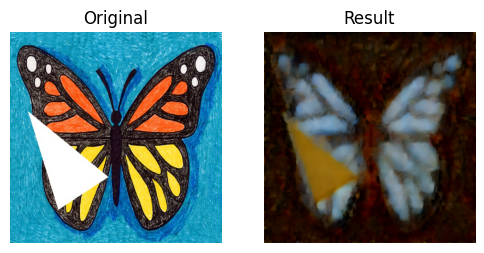

In [ ]:
seed = 170
#seed = torch.seed()
print('seed:',seed)
generator = torch.Generator(device).manual_seed(seed)
im_result = inpaint(prompt=['A pencil'],image=pil_image,mask_image=pil_mask,generator=generator).images[0]
show_images([pil_image,im_result],titles=['Original','Result'])

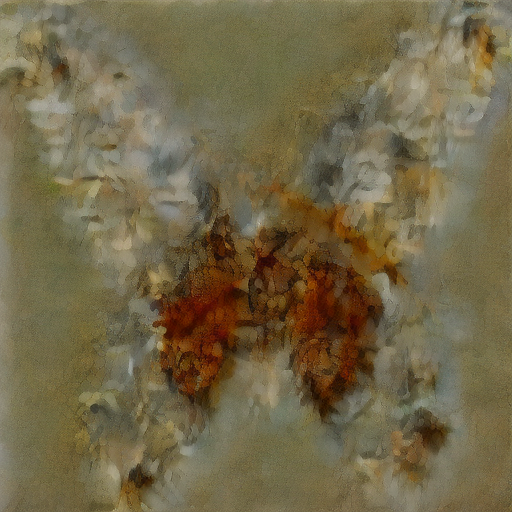

In [ ]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])

Inferencing with pipeline loaded with established pre-trained weights to see if it works well

In [ ]:
inpaint = StableDiffusionInpaintPipeline.from_pretrained("stabilityai/stable-diffusion-2-inpainting",
                                                         revision="fp16",
                                                         torch_dtype=torch.float16).to(device)  

unet/diffusion_pytorch_model.safetensors not found
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


seed: 170


  0%|          | 0/50 [00:00<?, ?it/s]

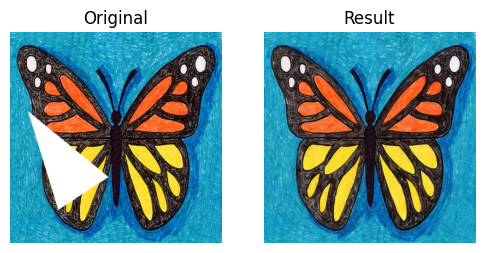

In [ ]:
seed = 170
#seed = torch.seed()
print('seed:',seed)
generator = torch.Generator(device).manual_seed(seed)
im_result = inpaint(prompt=['A pencil'],image=pil_image,mask_image=pil_mask,generator=generator).images[0]
show_images([pil_image,im_result],titles=['Original','Result'])

In [ ]:
!cp '/usr/local/lib/python3.10/dist-packages/diffusers/models/unet_2d_blocks.py' '.'

In [ ]:
state_dict = torch.load("/content/ddpm-butterflies-128/unet/diffusion_pytorch_model.bin")

In [ ]:
model.load_state_dict(state_dict)

<All keys matched successfully>

###To generate a random scratch in the image and get its mask using opencv

patch_area: 13107.2
current_area: 0.0 vs 655.3600000000001
current_area: 0.0 vs 655.3600000000001
current_area: 89835.0 vs 655.3600000000001


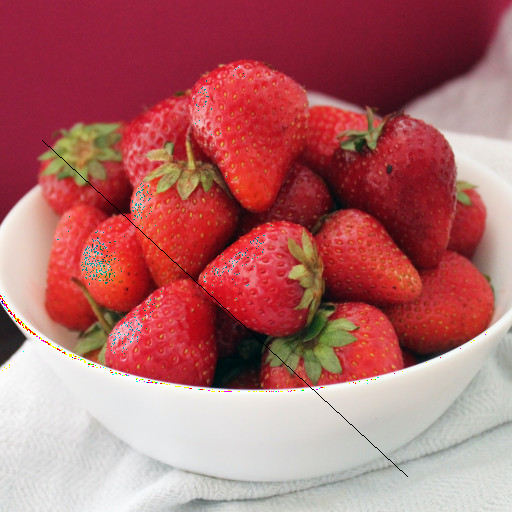

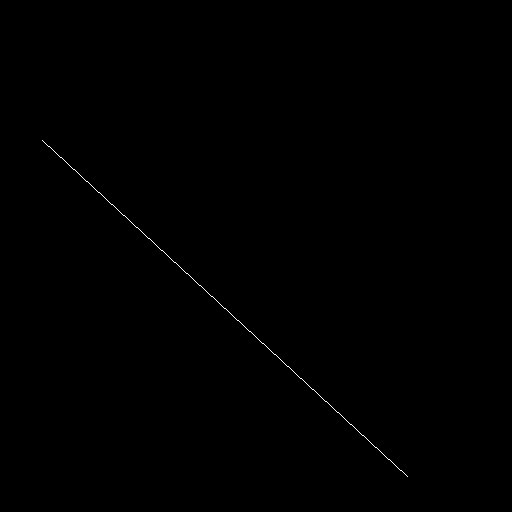

In [ ]:
# read the image
img = cv2.imread('/content/strawberry.png')

# get the dimensions of the image
height, width, _ = img.shape

# calculate the desired patch area
patch_area = 0.05 * height * width
print(f'patch_area: {patch_area}')

# generate random position for the patch
x = np.random.randint(0, width)
y = np.random.randint(0, height)

# generate random number of vertices for the patch
num_vertices = np.random.randint(3, 7)

# generate random vertices for the patch until the patch area is reached
vertices = []
current_area = 0
while current_area < 0.05 * patch_area:
    vertex_x = np.random.randint(0, width)
    vertex_y = np.random.randint(0, height)
    vertices.append((vertex_x, vertex_y))
    current_area = cv2.contourArea(np.array(vertices))
    print(f'current_area: {current_area} vs {0.05 * patch_area}')
vertices = vertices[:-1]
# create a white patch image with the same shape as the original image
patch = np.zeros_like(img)
cv2.fillPoly(patch, [np.array(vertices)], (255, 255, 255))

# add the white patch to the image
img = cv2.add(img, patch)
img[img == 255] = 0

# create a binary mask of the modified image
mask = np.zeros((height, width), dtype=np.uint8)
cv2.fillPoly(mask, [np.array(vertices)], 255)

# display the modified image and the mask
cv2_imshow(img)
cv2_imshow(mask)
cv2.waitKey(0)
cv2.destroyAllWindows()


###Inferencing based on Gradio Script

Reference script : https://github.com/Stability-AI/stablediffusion/blob/main/scripts/gradio/inpainting.py

In [ ]:
os.chdir('/content/')
!git clone https://github.com/anilbhatt1/stablediffusion.git

Cloning into 'stablediffusion'...
remote: Enumerating objects: 570, done.
remote: Counting objects: 100% (310/310), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 570 (delta 239), reused 212 (delta 212), pack-reused 260
Receiving objects: 100% (570/570), 73.43 MiB | 46.50 MiB/s, done.
Resolving deltas: 100% (271/271), done.


In [ ]:
%cd '/content/stablediffusion'
! ls

/content/stablediffusion
assets	     doc	       LICENSE	      README.md		setup.py
checkpoints  environment.yaml  LICENSE-MODEL  requirements.txt
configs      ldm	       modelcard.md   scripts


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
os.chdir('/content/')
!cp -r '/content/gdrive/MyDrive/EVA8_S15_Inpaint_Wt' '.'
!pwd

/content


In [ ]:
os.chdir('/content/stablediffusion')
!pwd
!ls

/content/stablediffusion
assets	     doc	       LICENSE	      README.md		setup.py
checkpoints  environment.yaml  LICENSE-MODEL  requirements.txt
configs      ldm	       modelcard.md   scripts


In [ ]:
import gradio as gr
from PIL import Image
from omegaconf import OmegaConf
from einops import repeat
from imwatermark import WatermarkEncoder
from pathlib import Path

In [ ]:
!cp '/content/stablediffusion/ldm/models/diffusion/ddim.py' '/content/stablediffusion'
!cp '/content/stablediffusion/ldm/models/diffusion/ddpm.py' '/content/stablediffusion'
!cp '/content/stablediffusion/ldm/util.py' '/content/stablediffusion'

In [ ]:
from ddim import DDIMSampler
from util import instantiate_from_config

In [ ]:
torch.set_grad_enabled(False)

In [ ]:
def put_watermark(img, wm_encoder=None):
    if wm_encoder is not None:
        img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        img = wm_encoder.encode(img, 'dwtDct')
        img = Image.fromarray(img[:, :, ::-1])
    return img

def initialize_model(config, ckpt):
    config = OmegaConf.load(config)
    model = instantiate_from_config(config.model)

    model.load_state_dict(torch.load(ckpt)["state_dict"], strict=False)

    device = torch.device(
        "cuda") if torch.cuda.is_available() else torch.device("cpu")
    model = model.to(device)
    sampler = DDIMSampler(model)

    return sampler

def make_batch_sd(
        image,
        mask,
        txt,
        device,
        num_samples=1):
    image = np.array(image.convert("RGB"))
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image).to(dtype=torch.float32) / 127.5 - 1.0

    mask = np.array(mask.convert("L"))
    mask = mask.astype(np.float32) / 255.0
    mask = mask[None, None]
    mask[mask < 0.5] = 0
    mask[mask >= 0.5] = 1
    mask = torch.from_numpy(mask)

    masked_image = image * (mask < 0.5)

    batch = {
        "image": repeat(image.to(device=device), "1 ... -> n ...", n=num_samples),
        "txt": num_samples * [txt],
        "mask": repeat(mask.to(device=device), "1 ... -> n ...", n=num_samples),
        "masked_image": repeat(masked_image.to(device=device), "1 ... -> n ...", n=num_samples),
    }
    print(f'num_samples : {num_samples}')
    print(f'type(batch["image"]) : {batch["image"].shape}')
    print(f'type(batch["txt"]) : {len(batch["txt"])} & {batch["txt"]}')
    print(f'type(batch["mask"]) : {batch["mask"].shape}')
    print(f'type(batch["masked_image"]) : {batch["masked_image"].shape}')
    return batch

In [ ]:
def inpaint(sampler, image, mask, prompt, seed, scale, ddim_steps, num_samples=1, w=512, h=512):
    device = torch.device(
        "cuda") if torch.cuda.is_available() else torch.device("cpu")
    model = sampler.model

    print("Creating... invisible watermark encoder (see https://github.com/ShieldMnt/invisible-watermark)...")
    wm = "SDV2"
    wm_encoder = WatermarkEncoder()
    wm_encoder.set_watermark('bytes', wm.encode('utf-8'))

    prng = np.random.RandomState(seed)
    start_code = prng.randn(num_samples, 4, h // 8, w // 8)
    start_code = torch.from_numpy(start_code).to(
        device=device, dtype=torch.float32)

    with torch.no_grad(), \
            torch.autocast("cuda"):
        batch = make_batch_sd(image, mask, txt=prompt,
                              device=device, num_samples=num_samples)

        c = model.cond_stage_model.encode(batch["txt"])
        print(f' inpaint c : {c.shape}')
        print(f' inpaint model.masked_image_key : {model.masked_image_key}')

        c_cat = list()
        for ck in model.concat_keys:
            print(f' inpaint ck : {ck}')
            cc = batch[ck].float()
            print(f' inpaint cc : {cc.shape}')
            if ck != model.masked_image_key:
                bchw = [num_samples, 4, h // 8, w // 8]
                print(f' inpaint bchw : {bchw} for ck : {ck}')
                cc = torch.nn.functional.interpolate(cc, size=bchw[-2:])
                print(f' inpaint cc after interpolate : {cc.shape}')
            else:
                cc = model.get_first_stage_encoding(
                    model.encode_first_stage(cc))
                print(f' inpaint cc.shape : {cc.shape} for ck : {ck}')
            c_cat.append(cc)
            print(f' inpaint c_cat : {len(c_cat)}')
        c_cat = torch.cat(c_cat, dim=1)
        print(f' inpaint c_cat after torch.cat : {c_cat.shape}')

        # cond
        cond = {"c_concat": [c_cat], "c_crossattn": [c]}

        # uncond cond
        uc_cross = model.get_unconditional_conditioning(num_samples, "")
        print(f' inpaint uc_cross.shape : {uc_cross.shape}')
        uc_full = {"c_concat": [c_cat], "c_crossattn": [uc_cross]}

        shape = [model.channels, h // 8, w // 8]
        print(f' inpaint shape : {shape}')
        samples_cfg, intermediates = sampler.sample(
            ddim_steps,
            num_samples,
            shape,
            cond,
            verbose=False,
            eta=1.0,
            unconditional_guidance_scale=scale,
            unconditional_conditioning=uc_full,
            x_T=start_code,
        )
        x_samples_ddim = model.decode_first_stage(samples_cfg)

        result = torch.clamp((x_samples_ddim + 1.0) / 2.0,
                             min=0.0, max=1.0)

        result = result.cpu().numpy().transpose(0, 2, 3, 1) * 255
        result_1 = [put_watermark(Image.fromarray(img.astype(np.uint8)), wm_encoder) for img in result]
        im0 = result_1[0].save('/content/im0.jpg')
        im1 = result_1[1].save('/content/im1.jpg')
        print(f'im0.jpg & im1.jpg saved against num_samples of {num_samples}')
    return [put_watermark(Image.fromarray(img.astype(np.uint8)), wm_encoder) for img in result]

In [ ]:
def pad_image(input_image):
    pad_w, pad_h = np.max(((2, 2), np.ceil(
        np.array(input_image.size) / 64).astype(int)), axis=0) * 64 - input_image.size
    im_padded = Image.fromarray(
        np.pad(np.array(input_image), ((0, pad_h), (0, pad_w), (0, 0)), mode='edge'))
    return im_padded

def predict(input_image, prompt, ddim_steps, num_samples, scale, seed):
    init_image = input_image["image"].convert("RGB")
    init_mask = input_image["mask"].convert("RGB")
    image = pad_image(init_image) # resize to integer multiple of 32
    mask = pad_image(init_mask) # resize to integer multiple of 32
    width, height = image.size
    print("Inpainting...", width, height)

    result = inpaint(
        sampler=sampler,
        image=image,
        mask=mask,
        prompt=prompt,
        seed=seed,
        scale=scale,
        ddim_steps=ddim_steps,
        num_samples=num_samples,
        h=height, w=width
    )

    return result

In [ ]:
config_inpaint = '/content/stablediffusion/configs/stable-diffusion/v2-inpainting-inference.yaml'
model_path = '/content/gdrive/MyDrive/EVA8_S15_Inpaint_Wt/512-inpainting-ema.ckpt'
sampler = initialize_model(config_inpaint, model_path)

No module 'xformers'. Proceeding without it.
LatentInpaintDiffusion: Running in eps-prediction mode
DiffusionWrapper has 865.93 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Downloading: "https://github.com/DagnyT/hardnet/raw/master/pretrained/train_liberty_with_aug/checkpoint_liberty_with_aug.pth" to /root/.cache/torch/hub/checkpoints/checkpoint_liberty_with_aug.pth
100%|██████████| 5.10M/5.10M [00:00<00:00, 68.3MB/s]
/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:49: DeprecationWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", DeprecationWarning)


In [ ]:
type(sampler)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ddim.DDIMSampler

In [ ]:
model = sampler.model

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
type(model)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ldm.models.diffusion.ddpm.LatentInpaintDiffusion

In [ ]:
def generate_image_mask(input_path, output_img_path, output_mask_path):
    # read the image
    img = cv2.imread(input_path)

    # get the dimensions of the image
    height, width, _ = img.shape

    # calculate the desired patch area
    patch_area = 0.05 * height * width
    print(f'patch_area: {patch_area}')

    # generate random position for the patch
    x = np.random.randint(0, width)
    y = np.random.randint(0, height)

    # generate random number of vertices for the patch
    num_vertices = np.random.randint(3, 7)

    # generate random vertices for the patch until the patch area is reached
    vertices = []
    current_area = 0
    while current_area < 0.05 * patch_area:
        vertex_x = np.random.randint(0, width)
        vertex_y = np.random.randint(0, height)
        vertices.append((vertex_x, vertex_y))
        current_area = cv2.contourArea(np.array(vertices))
        print(f'current_area: {current_area} vs {0.05 * patch_area}')
    vertices = vertices[:-1]
    # create a white patch image with the same shape as the original image
    patch = np.zeros_like(img)
    cv2.fillPoly(patch, [np.array(vertices)], (255, 255, 255))

    # add the white patch to the image
    img = cv2.add(img, patch)
    img[img == 255] = 0

    # create a binary mask of the modified image
    mask = np.zeros((height, width), dtype=np.uint8)
    cv2.fillPoly(mask, [np.array(vertices)], 255)

    img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_NEAREST)
    mask = cv2.resize(mask, (512, 512), interpolation=cv2.INTER_NEAREST)

    cv2.imwrite(output_img_path, img)
    cv2.imwrite(output_mask_path, mask)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
input_path = '/content/img00020.jpg'
output_img_path = '/content/img00020_mod.jpg'
output_mask_path = '/content/img00020_mask.jpg'
generate_image_mask(input_path, output_img_path, output_mask_path)
input_image = {}
pil_image = Image.open(output_img_path)
pil_mask = Image.open(output_mask_path)
input_image["image"] = pil_image
input_image["mask"] = pil_mask
prompt = 'Same background'
ddim_steps = 30
num_samples = 2
scale = 7
seed = 10

patch_area: 1680.0
current_area: 0.0 vs 84.0
current_area: 0.0 vs 84.0
current_area: 2818.0 vs 84.0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
result = predict(input_image, prompt, ddim_steps, num_samples, scale, seed)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Inpainting... 512 512
Creating... invisible watermark encoder (see https://github.com/ShieldMnt/invisible-watermark)...
num_samples : 2
type(batch["image"]) : torch.Size([2, 3, 512, 512])
type(batch["txt"]) : 2 & ['Same background', 'Same background']
type(batch["mask"]) : torch.Size([2, 1, 512, 512])
type(batch["masked_image"]) : torch.Size([2, 3, 512, 512])
 inpaint c : torch.Size([2, 77, 1024])
 inpaint model.masked_image_key : masked_image
 inpaint ck : mask
 inpaint cc : torch.Size([2, 1, 512, 512])
 inpaint bchw : [2, 4, 64, 64] for ck : mask
 inpaint cc after interpolate : torch.Size([2, 1, 64, 64])
 inpaint c_cat : 1
 inpaint ck : masked_image
 inpaint cc : torch.Size([2, 3, 512, 512])
 inpaint cc.shape : torch.Size([2, 4, 64, 64]) for ck : masked_image
 inpaint c_cat : 2
 inpaint c_cat after torch.cat : torch.Size([2, 5, 64, 64])
 inpaint uc_cross.shape : torch.Size([2, 77, 1024])
 inpaint shape : [4, 64, 64]
Data shape for DDIM sampling is (2, 4, 64, 64), eta 1.0
Running DDIM

DDIM Sampler: 100%|██████████| 31/31 [00:15<00:00,  2.02it/s]


im0.jpg & im1.jpg saved against num_samples of 2


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


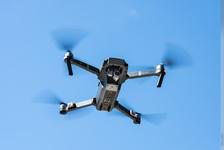

In [ ]:
#Original image
Image.open('/content/img00020.jpg')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


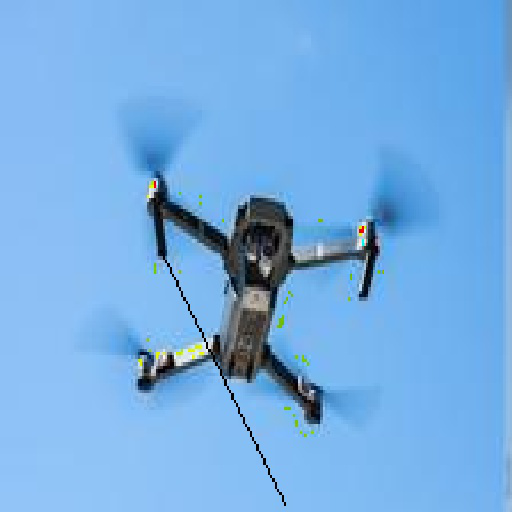

In [ ]:
#Image with patch in it
Image.open('/content/img00020_mod.jpg')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


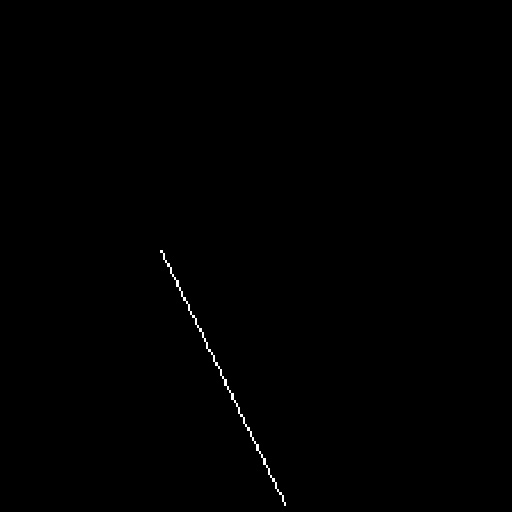

In [ ]:
#Corresponding mask
Image.open('/content/img00020_mask.jpg')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


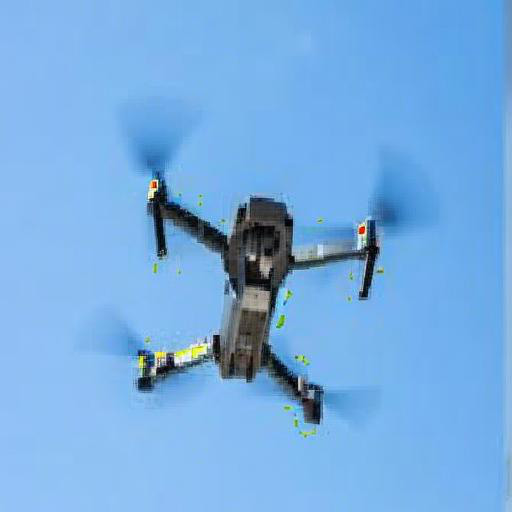

In [ ]:
# Result -1 
Image.open('/content/im0.jpg')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


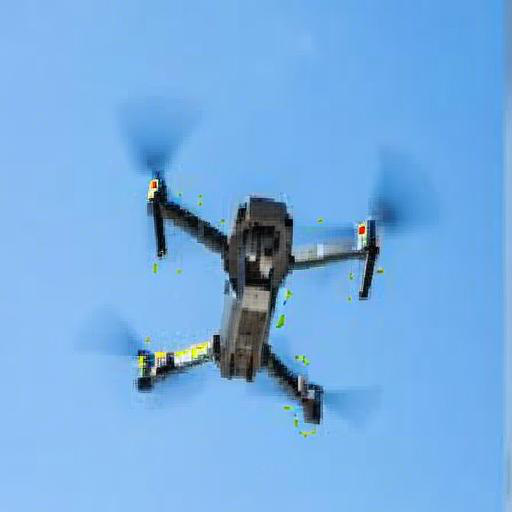

In [ ]:
# Result -2
Image.open('/content/im1.jpg')